# Maximum Entropy Approximation - Joint distribution  P(m, p)

(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
import os
import glob
import dill
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy

# Import library to perform maximum entropy fits
from maxentropy.skmaxent import FeatureTransformer, MinDivergenceModel
# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/MaxEnt_approx_joint/'
datadir = '../../data/csv_maxEnt_dist/'

### $\LaTeX$ macros

$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{avg}[1]{\left\langle #1 \right\rangle}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{ll}[1]{\underset{\sim}{#1}}$
---

# The joint distribution $P(m, p)$ using MaxEnt.

So far we used the MaxEnt approach to approximate the marginal distributions for mRNA $P(m)$ and protein $P(p)$. In reality since the protein copy number depends on the mRNA count we have a joint distribution $P(m, p)$. By definition the marginals we have computed are of the form
$$
P(m) \equiv \sum_p P(m, p),
\tag{1}
$$
and
$$
P(p) \equiv \sum_m P(m, p),
\tag{2}
$$

This joint distribution could contain relevant information that we lose when performing these marginalizations. Therefore in this notebook we will use the exact same MaxEnt approach as before to compute the joint distribution.

For the case of the joing distribution we have moments for the mRNA marginal distribution
$$
\ee{m^i} \equiv \sum_m \sum_p m^i P(m, p),
\tag{3}
$$
and equivalent moments for the protein distribution
$$
\ee{p^i} \equiv \sum_m \sum_p p^i P(m, p).
\tag{4}
$$

We also know the steady-state value of cross-correlations of the form
$$
\ee{m^i p^j} \equiv \sum_m \sum_p m^i p^j P(m, p), 
\tag{5}
$$
where $i, j \in \{1, 2\}$.

Using these moments we can follow the exact same strategy to compute the MaxEnt approximation of the joint distribution.

That means that our MaxEnt approximate joint distribution $P_H(m, p)$ is of the form
$$
P_H(m, p) = {1 \over \mathcal{Z}} \exp \left[
\sum_{i=1}^3\lambda_i^{(m)} m^i +
\sum_{j=1}^3\lambda_j^{(p)} p^j +
\sum_{i,j \in \{1, 2\}}\lambda_{ij}^{(mp)} m^i p^j
\right],
\tag{6}
$$
where all the $\lambda$ terms represent the Lagrange multipliers that need to be numerically determined.

Given this form of the distribution the MaxEnt moments $\ee{m^ip^j}_H$ are given by
$$
\ee{m^ip^j}_H \equiv \sum_m \sum_p m^ip^j P_H(m, p).
\tag{7}
$$

Let's now look into how to obtain the value of the Lagrange multipliers.

## The Newton-Raphson algorithm

Following [Smadbeck & Kaznessis, 2013](http://www.pnas.org/content/110/35/14261) we will use a Newton-Raphson algorithm to get at the value of these Lagrange multipliers.

Let $\ll{\lambda}$ be an array containing all Lagrange multipliers, and $\ll{\mu_H}$ be the estimate of all the MaxEnt moments computed using $P_H(m, p)$. The steps listed by the authors go as follows:

1. Initialize Lagrange multipliers $\ll{\lambda} = \ll{\lambda_0}$ (Typically a guess of all zeros works).
2. Calculate the joint distribution $P_H(m, p)$ as determined by Eq. 6.
3. Calculate the moments used for the constraints $\ll{\mu_H}$ with Eq. 7.
4. Calculate the difference between the **known** moments and the MaxEnt estimates as
$$
\Delta\ll{\mu} = \ll{\mu} - \ll{\mu_H}.
\tag{8}
$$
5. Calculate the 2-norm error with
$$
\varepsilon = \ll{\mu_H}^T \ll{\mu_H}
\tag{9}
$$
6. If $\varepsilon \leq$ `tol` (i.e. a user determined tolerance value) proceed to the last step 7. Otherwise

    a. Calculate the Jacobian Matrix $\bb{J}$ with entries
    $$
    J_{i,j} \equiv {\partial \mu_{H,i} \over \partial \lambda_j}.
    \tag{10}
    $$
    (We'll come back to how to compute this matrix)
    b. The Newton-Raphson method uses a first-order Taylor expansion of the form
    $$
    \Delta\ll{\mu} \approx \bb{J} \Delta \ll{\lambda}.
    \tag{11}
    $$
    Therefore we can estimate the step size for each of our Lagrange multipliers
    as
    $$
    \Delta \ll{\lambda} \approx \bb{J}^{-1} \Delta\ll{\mu}
    \tag{12}
    $$
    c. Using this approximation we update our estimates for the i$^{\text{th}}$
    iteration as
    $$
    \ll{\lambda}^{(i + 1)} = \ll{\lambda}^{(i)} + \Delta \ll{\lambda}
    \tag{13}
    $$
    d. Repeat from step 2.
7. Once the $\varepsilon \leq$ `tol` relationship is satisfied return the Lagrange multipliers values $\ll{\lambda}$

## Jacobian Matrix $\bb{J}$

To compute the derivative from Eq. 10 we need to be very careful with the indexing. First we will rewrite the MaxEnt distribution (Eq. 6) as
$$
P_H(m, p) = {1 \over \mathcal{Z}} \exp \left[
- \sum_{i=1}^N \lambda_i m^{x_i} p^{y_i},
\right],
\tag{14}
$$
where we index all Lagrange multipliers $\lambda_i$ to be associated with each of the constraints of the form $\ee{m^{x_i} p^{y_i}}$. In our specific case we have the Lagrange multipliers of the form:
$$
\left\{
\lambda_1 : \ee{m},
\lambda_2 : \ee{m^2},
\lambda_3 : \ee{m^3},\\
\lambda_4 : \ee{p},
\lambda_5 : \ee{p^2},
\lambda_6 : \ee{p^3},\\
\lambda_7 : \ee{mp},
\lambda_8 : \ee{m^2p},
\lambda_9 : \ee{mp^2}
\right\}
\tag{15}
$$

This implies that Eq. 10 is given by
$$
J_{i,j} = {\partial \over \partial \lambda_j} \ee{m^{x_i} p^{y_j}}_H.
\tag{16}
$$
Combining Eq. 7 and Eq. 14 gives
$$
J_{i,j} = {\partial \over \partial \lambda_j}\left(
\sum_m \sum_p m^{x_i} p^{y_i}
{1 \over \mathcal{Z}} \exp \left[
- \sum_{k=1}^N \lambda_k m^{x_k} p^{y_k},
\right]
\right).
\tag{17}
$$
Evaluating this derivative gives
$$
J_{i,j} = \sum_m \sum_p \left( m^{x_i} p^{y_i} \right)
\left( - m^{x_j} p^{y_j}  \right)
{1 \over \mathcal{Z}} \exp \left[
- \sum_{k=1}^N \lambda_k m^{x_k} p^{y_k}
\right].
\tag{18}
$$
This is simplified to
$$
J_{i,j} = - \ee{m^{x_i + x_j} p ^{y_i + y_j}}_H
\tag{19}
$$

### Implementing the algorithm.

In the following steps we will be implementing such algorithm

The first thing we will define is a function to compute the "product space" $m^x p^y$ for a given selection of $m$ andp $p$ values. These products will be fed to the algorithm as a pre-computed entry.

We will also define the "logsum space" defined as $x\cdot \ln m + y\cdot \ln p$ for a given selection of $m$ and $p$ values. This will be useful when computing log probabilities and log moments.

In [16]:
def product_space(mRNA, protein, exponents=[0, 0]):
    '''
    Computes all the products of the form m**x * p**y for all possible pairs
    of m and p given in the mRNA and protein arrays.
    Parameters
    ----------
    mRNA, protein : array-like.
        Selected range of mRNA and protein to be used as sample space for the
        distribution
    exponents : array-like. 2x1
        Exponents for the product.
        exponents[0] = mRNA exponent x
        exponents[1] = mRNA exponent y
    Returns
    -------
    prod_space : array-like. len(mRNA) x len(protein).
        All possible pairwise products.
        rows = mRNA
        columns = protein
    '''
    # Build mRNA and protein grid
    mm, pp = np.meshgrid(mRNA, protein)
    
    # Compute product and return all possible pairwise products
    return (mm**exponents[0] * pp**exponents[1]).T


def logsum_space(mRNA, protein, exponents=[0, 0]):
    '''
    Computes all the sums of the form x * ln(m) + y * ln(p) for 
    all possible pairs of m and p given in the mRNA and protein arrays.
    Parameters
    ----------
    mRNA, protein : array-like.
        Selected range of mRNA and protein to be used as sample space for the
        distribution
    exponents : array-like. 2x1
        Exponents for the product.
        exponents[0] = mRNA exponent x
        exponents[1] = mRNA exponent y
    Returns
    -------
    sum_space : array-like. len(mRNA) x len(protein).
        All possible pairwise sums.
        rows = mRNA
        columns = protein
    '''
    # Convert to decimal points
    mRNA = mRNA.astype('float')
    protein = protein.astype('float')
    
    # Check for zeros and change it to numerical precision
    mRNA[mRNA == 0] = 1E-323
    protein[protein == 0] = 1E-323
    
    # Build log mRNA and log protein grid
    logmm, logpp = np.meshgrid(np.log(mRNA), np.log(protein))
    
    # Compute product and return all possible pairwise products
    return (exponents[0] * logmm + exponents[1] * logpp).T

Having this in hand let's define a function that takes an array of Lagrange multipliers `lambda_array` and a 3D array `products` of pre-computed products products and returns the **MaxEnt** probability distribution for each entry $(m, p)$

In [17]:
def MaxEnt_joint_dist(lambda_array, products, log=False):
    '''
    Computs the MaxEnt probability distribution given constraints captured
    by the Lagrange multipliers in the lambda_array list and all the products
    associated with each of the Lagrange multipliers
    Parameters
    ----------
    lambda_array : array-like. 1 x N.
        List of Lagrange multipliers to be used to compute the MaxEnt
        distribution.
        N = Number of constraints
    product : ndarray. mRNA x protein x N
        3D array with matrices containing the products associated with each
        of the Lagrange multipliers.
    log : bool. Default = False
        Boolean indicating if the Log probability should be returned instead
        For this the function usies scipy.misc.logsumexp to perform the 
        summation
    Returns
    -------
    MaxEnt_dist: array-like. len(mRNA) x len(protein)
        Maximum entropy distribution for each pairwise m,p entry
    '''
    # Confirm that the number of constraints is the same as the number of 
    # associated products
    if len(lambda_array) != products.shape[0]:
        raise ValueError('The number of constraints must be the same as '+\
                         'the number of given products')
    
    # Compute -∑ lambda_i m**x_i * p**y_i
    lambdas_mp = - np.sum(products * \
                   np.array(lambda_array)[:, np.newaxis, np.newaxis],
                          axis=0)
    # Compute logZ
    logZ = scipy.special.logsumexp(lambdas_mp)
    
    # Check if the log probability or the probability were requested
    if log:
        return lambdas_mp - logZ
    else:
        return np.exp(lambdas_mp) / np.exp(logZ)


Now we need a function that computes the moment $\ee{m^x p^y}_H$ as defined in Eq. 7 **given a pre-computed** maximum entropy distribution $P_H(m, y)$.

In [18]:
def MaxEnt_joint_moment(mRNA, protein, dist, exponents, log=False):
    '''
    Computes the moment <m**x * p**y> (or log moment) given a pre-computed 
    distribution dist and sample space mRNA and protein.
    Parameters
    ----------
    mRNA, protein : array-like.
        Selected range of mRNA and protein to be used as sample space for the
        distribution
    dist : array-like. len(mRNA) x len(protein)
        Joint distribution of protein and mRNA.
    exponents : array-like. 2x1
        Exponents for the product.
        exponents[0] = mRNA exponent x
        exponents[1] = mRNA exponent y
    log : bool. Default = False.
        Boolean indicating if log(<m**x * p**y>) should be computed.
        NOTE: If True dist is assumed to be the log probability!
    Returns
    -------
    The moment (or log moment)
    '''
    # Check that the distribution is the same size as the sample space
    if (len(mRNA) != dist.shape[0]) or (len(protein) != dist.shape[1]):
        raise ValueError('The sample space and the distribution have' +\
                        'different sizes.')
    
    # Check if the log moment was requested
    if log:
        # Compute the log moment as the 
        # log(sum(exp(x ln m + y ln p + logP)))
        return scipy.special.logsumexp(logsum_space(mRNA, protein, exponents)\
                                      + dist)
    else:
        # Perform product and multiply by probability distribution
        return np.sum(product_space(mRNA, protein, exponents) * dist)

---
### Computing the linear residuals for minimization.

Having defined these functions let's define a function that computes the residuals between the expectd moments and the MaxEnt moments along with a function that computes the Jacobian and Hessian matrix.

In [19]:
def MaxEnt_resid(param, constraints, products):
    '''
    Computes the residual between the expected moments and the MaxEnt
    approximate moments. This function will be used by the minimization
    procedure to obtain the value of the Lagrante multipliers.
    Parameters
    ----------
    param : array-like.
        Array containing the value of the Lagrange multipliers associated
        with each of the constraints.
    constraints : array-like.
        Value of the expected moments of the form <m**x * p**y>
        corresponding to each of the Lagrange multipliers.
    products : ndarray. len(constraints) x len(mRNA) x len(protein)
        Array containing the pre-computed products of the form
        m**x * p**y associated with each of the constraints.
    Returns
    -------
    Difference between expected moments and MaxEnt moments
    '''
    # Compute probability distribution
    Pmp = MaxEnt_joint_dist(param, products)

    # Calculate moments associated with constraints
    maxent_moments = np.array([np.sum(x * Pmp) for x in products])

    # Compute the ∆moments
    return constraints - maxent_moments


def MaxEnt_jacobian(param, constraints, products,
                    mRNA, protein, exponents):
    '''
    Computes the Jacobian matrix in which each entry is the derivative
    of the moment <m**x_i * p**y_i> with respect to the jth lagrange
    multiplier. This results in
    d <m**x_i * p**y_i> / d lambda_j =  - <m**(x_i + x_j) * p**(y_i + y_j)>
    Parameters
    ----------
    param : array-like.
        Array containing the value of the Lagrange multipliers associated
        with each of the constraints.
    constraints : array-like.
        Value of the expected moments of the form <m**x * p**y>
        corresponding to each of the Lagrange multipliers.
    products : PLACEHOLDER
        Dummy variable necessary to be included for the scipy funciton to
        work. This function DOES NOT use the pre-computed products since 
        the moments to be calculated depend on the derivative been taken.
    mRNA, protein : array-like.
        Selected range of mRNA and protein to be used as sample space for the
        distribution
    exponents : array-like. 2x1
        Exponents for the product.
        exponents[0] = mRNA exponent x
        exponents[1] = mRNA exponent y
    Returns
    -------
    Jacobian matrix
    '''
    # Compute probability distribution
    Pmp = MaxEnt_joint_dist(param, products)
    
    # Initialize matrix
    Jacobian = np.zeros([len(exponents), len(exponents)])
    # Loop through exponents computing each entry of the matrix
    for i, expi in enumerate(exponents):
        for j, expj in enumerate(exponents):
            Jacobian[i, j] = - MaxEnt_joint_moment(mRNA, protein, Pmp, 
                               np.array(expi) + np.array(expj))

    return Jacobian


def MaxEnt_hessian(param, constraints, products,
                    mRNA, protein, exponents):
    '''
    Computes the Hessian matrix in which each entry is the second
    derivative of the moment <m**x_i * p**y_i> with respect to 
    the ith and the jth lagrange multiplier. This results in
    d**2 <m**x_i * p**y_i> / d lambda_i d lambda_j=  \
    <m**(2 * x_i + x_j) * p**(2 * y_i + y_j)>
    Parameters
    ----------
    param : array-like.
        Array containing the value of the Lagrange multipliers associated
        with each of the constraints.
    constraints : array-like.
        Value of the expected moments of the form <m**x * p**y>
        corresponding to each of the Lagrange multipliers.
    products : PLACEHOLDER
        Dummy variable necessary to be included for the scipy funciton to
        work. This function DOES NOT use the pre-computed products since 
        the moments to be calculated depend on the derivative been taken.
    mRNA, protein : array-like.
        Selected range of mRNA and protein to be used as sample space for the
        distribution
    exponents : array-like. 2x1
        Exponents for the product.
        exponents[0] = mRNA exponent x
        exponents[1] = mRNA exponent y
    Returns
    -------
    Hessian matrix
    '''
    # Compute probability distribution
    Pmp = MaxEnt_joint_dist(param, products)
    
    # Initialize matrix
    Hessian = np.zeros([len(exponents), len(exponents)])
    # Loop through exponents computing each entry of the matrix
    for i, expi in enumerate(exponents):
        for j, expj in enumerate(exponents):
            Hessian[i, j] = MaxEnt_joint_moment(mRNA, protein, Pmp, 
                               2 * np.array(expi) + np.array(expj))

    return Hessian

---
### Computing the log residuals for minimization.

As an alternative approach that can be numerically more stable we will now define functions to compute the difference between the log expected moment and the log MaxEnt moment.

The log expected moment is simply computed numerically by taking the log of the value that we want the MaxEnt to be satisfied $\ln \ee{m^x p^y}$.

The log of the MaxEnt moment is computed using the `scipy.special.logsumexp` function that is more stable when performing sums of the form $\log \sum_x e^x$. We have that the log joint probability distribution is of the form
$$
\log P(m, p) = - \sum_{i=1}^N \left[\lambda_i m^{x_i} p^{y_i}\right] -
\log \mathcal{Z}.
\tag{20}
$$
So computing the log of a moment using the log probability distribution can be done as
$$
\log \ee{m^x p^y}_H = \log \sum_m \sum_p \left[ m^x p^y 
\exp\left(\log P(m, x)\right) \right],
\tag{21}
$$
which can be rewritten as
$$
\log \ee{m^x p^y}_H = \log \sum_m \sum_p \exp \left[ x \log m + y \log p +
\log P(m, x) \right].
\tag{22}
$$
So with this in hand we will implement a function to compute the residuals $\ln \ee{m^x p^y} - \ln \ee{m^x p^y}_H$

In [20]:
def MaxEnt_log_resid(param, constraints, products, logsums):
    '''
    Computes the residual between the log expected moments and the MaxEnt
    approximate log moments. This function will be used by the minimization
    procedure to obtain the value of the Lagrante multipliers.
    Parameters
    ----------
    param : array-like.
        Array containing the value of the Lagrange multipliers associated
        with each of the constraints.
    constraints : array-like.
        Value of the expected moments of the form <m**x * p**y>
        corresponding to each of the Lagrange multipliers.
    products : ndarray. len(constraints) x len(mRNA) x len(protein)
        Array containing the pre-computed products of the form
        m**x * p**y associated with each of the constraints.
    logsums : ndarray. len(constraints) x len(mRNA) x len(protein)
        Array containing the pre-computed sums of the form
        x * log(m) + y * log(p) associated with each of the constraints.   
    Returns
    -------
    Difference between log expected moments and MaxEnt log moments
    '''
    # Compute probability distribution
    logPmp = MaxEnt_joint_dist(param, products, log=True)

    # Calculate moments associated with constraints
    logmaxent_moments = np.array([scipy.special.logsumexp(x + logPmp)\
                               for x in logsums])

    # Compute the ∆moments
    return constraints - logmaxent_moments


def MaxEnt_log_jacobian(param, constraints, products, logsums,
                        mRNA, protein, exponents):
    '''
    Computes the Jacobian matrix in which each entry is the derivative
    of the moment <m**x_i * p**y_i> with respect to the jth lagrange
    multiplier. This results in
    d log<m**x_i * p**y_i> / d lambda_j =\
    - <m**(x_i + x_j) * p**(y_i + y_j)> / <m**x_i * p**y_i>
    Parameters
    ----------
    param : array-like.
        Array containing the value of the Lagrange multipliers associated
        with each of the constraints.
    constraints : array-like.
        Value of the expected moments of the form <m**x * p**y>
        corresponding to each of the Lagrange multipliers.
    products : ndarray. len(constraints) x len(mRNA) x len(protein)
        Array containing the pre-computed products of the form
        m**x * p**y associated with each of the constraints.
    logsums : ndarray. len(constraints) x len(mRNA) x len(protein)
        Array containing the pre-computed sums of the form
        x * log(m) + y * log(p) associated with each of the constraints. 
    mRNA, protein : array-like.
        Selected range of mRNA and protein to be used as sample space for the
        distribution
    exponents : array-like. 2x1
        Exponents for the product.
        exponents[0] = mRNA exponent x
        exponents[1] = mRNA exponent y
    Returns
    -------
    Jacobian matrix
    '''
    # Compute probability distribution
    Pmp = MaxEnt_joint_dist(param, products)
    
    # Initialize matrix
    Jacobian = np.zeros([len(exponents), len(exponents)])
    # Loop through exponents computing each entry of the matrix
    for i, expi in enumerate(exponents):
        for j, expj in enumerate(exponents):
            Jacobian[i, j] = + MaxEnt_joint_moment(mRNA, protein, Pmp, 
                               np.array(expi) + np.array(expj)) /\
                            MaxEnt_joint_moment(mRNA, protein, Pmp, 
                               np.array(expi))

    return Jacobian

# Two-state unregulated promoter
---

As an exercise to test the performance of this approximation let's fit the Maximum entropy model to the two-state unregulated promoter model. 

Let's define the parameters for the *lacUV5* unregulated promoter.

In [21]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1)

# define protein degradation rate in units of mRNA degradation rate
gp = 0.000277 / 0.00284 
par_UV5['gp'] = gp

# define rp based on the mean protein copy number per mRNA
par_UV5['rp'] = 1000 * par_UV5['gp']

text

In [22]:
# Extract the parameters in order to feed them to the moment functions
m_param = ['kp_on', 'kp_off', 'rm', 'gm']
p_param = ['kp_on', 'kp_off', 'rm', 'gm', 'rp', 'gp']
par_m = [par_UV5.get(x) for x in m_param]
par_p = [par_UV5.get(x) for x in p_param]

# Write down the constraints
# mRNA
mRNA_moments = [chann_cap.first_unreg_m(*par_m),\
             chann_cap.second_unreg_m(*par_m),\
             chann_cap.third_unreg_m(*par_m)]
# Protein
protein_moments = [chann_cap.first_unreg_p(*par_p),\
                chann_cap.second_unreg_p(*par_p),\
                chann_cap.third_unreg_p(*par_p)]
# Cross-correlations
correlations = [chann_cap.mp_unreg_p(*par_p),\
                chann_cap.m2p_unreg_p(*par_p),\
                chann_cap.mp2_unreg_p(*par_p)]

constraints = np.array(mRNA_moments + protein_moments + correlations)

# Define exponents
exponents = ([1, 0], [2, 0], [3, 0],
             [0, 1], [0, 2], [0, 3],
             [1, 1], [2, 1], [1, 2])

In order to define a computationally more efficient sample space we will make use of what we know about the first and second moment. We will define the sample space as mean $\pm $  $Y \times$ standard deviation, where $Y$ is some factor.

Let's define this sample space.

In [23]:
# Extract moments
mRNA_mean = mRNA_moments[0]
mRNA_std = np.sqrt(mRNA_moments[1] - mRNA_mean**2)
protein_mean = protein_moments[0]
protein_std = np.sqrt(protein_moments[1] - protein_mean**2)

# Compute range
std_factor = 4
mRNA_range = [int(x) for x in [mRNA_mean - std_factor * mRNA_std,
              mRNA_mean + std_factor * mRNA_std]]
protein_range = [int(x) for x in [protein_mean - std_factor * protein_std,
                 protein_mean + std_factor * protein_std]]

# Define sample space
mRNA_space = np.arange(*mRNA_range)
protein_space = np.arange(*protein_range)

# Eliminate negative numbers
mRNA_space = mRNA_space[mRNA_space >= 0]
protein_space = protein_space[protein_space >= 0]

mRNA_space = np.arange(max(mRNA_range))
protein_space = np.arange(max(protein_range))

In [47]:
protein_space

array([    0,     1,     2, ..., 21923, 21924, 21925])

Now let's fit the distribution.

In [27]:
constraints = np.array(mRNA_moments + protein_moments + correlations)

# Define exponents
exponents = ([1, 0], [2, 0], [3, 0],
             [0, 1], [0, 2], [0, 3],
             [1, 1], [2, 1], [1, 2])

idx = [0, 1, 2, 3, 4]#, 6]#, 7, 8]
constraints = np.array([constraints[x] for x in idx])
exponents = np.array([exponents[x] for x in idx])

products = np.zeros([len(constraints), len(mRNA_space), len(protein_space)])
logsums = np.zeros([len(constraints), len(mRNA_space), len(protein_space)])
for i, exp in enumerate(exponents):
    products[i, :, :] = product_space(mRNA_space, protein_space, exp)
    logsums[i, :, :] = logsum_space(mRNA_space, protein_space, exp)
    
p0 = np.zeros_like(constraints) 
args = (np.log(constraints), products, logsums)

In [61]:
scipy.optimize.least_squares?

In [35]:
jac = lambda param, c, p, l:\
        MaxEnt_log_jacobian(param, c, p, l, mRNA_space, 
                        protein_space, exponents)
    
popt = scipy.optimize.least_squares(MaxEnt_log_resid, p0, args=args)
popt.x

KeyboardInterrupt: 

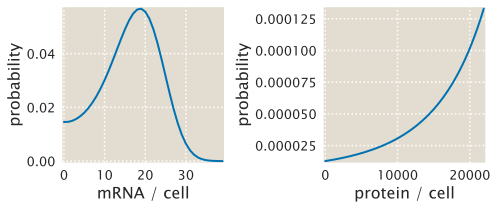

In [34]:
# Compute the probability distribution given the fit Lagrange multipliers
Pmp = MaxEnt_joint_dist(popt.x, products)

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Plot mRNA dist
ax[0].plot(mRNA_space, Pmp.sum(axis=1))
ax[0].set_xlabel('mRNA / cell')
ax[0].set_ylabel('probability')
ax[0].margins(0.01)

# Plot protein dist
ax[1].plot(protein_space, Pmp.sum(axis=0))
ax[1].set_xlabel('protein / cell')
ax[1].set_ylabel('probability')
ax[1].margins(0.01)

plt.tight_layout()

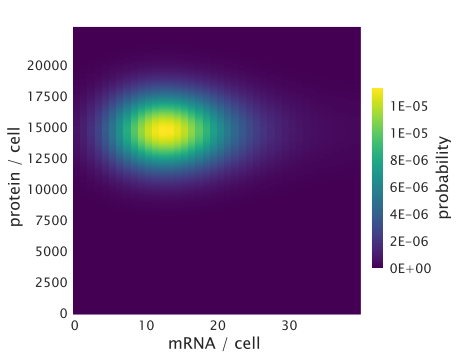

In [32]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot something in the range to keep the axis of this plot
ax.plot([mRNA_space.min(), mRNA_space.max()],
        [protein_space.min(), protein_space.max()])

# Reduce the margins so that it is only the plotting area we desire
ax.margins(0)

# Label axis
ax.set_xlabel('mRNA / cell')
ax.set_ylabel('protein / cell')

# Generate a new axis to add the heatmap
ax2 = fig.add_axes([0.12, 0.12, 0.8, 0.8], anchor='NE', zorder=0)

# Plot heatmap in new axis
cax = ax2.matshow(Pmp.T, aspect='auto', cmap='viridis', origin='lower')
# turn off secondary plot axis
ax2.axis('off')

# Generate a colorbar with the concentrations
cbar_ax = fig.add_axes([0.95, 0.25, 0.03, 0.5])

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, cax=cbar_ax, format='%.0E')

# Label colorbar
cbar.set_label('probability')
# plt.savefig(figdir + 'MaxEnt_joint_PMF_unreg.pdf', bbox_inches='tight')

---
# To be continued...
---

In [161]:
def MaxEnt_newton_raphson(mRNA, protein, constraints, exponents, 
                          lambda0=None, tol=1E-4, maxiter=1000, 
                          verbose=False, loop_print=25):
    '''
    Implementation of the Newton-Raphson algorithm as defined by Smadbeck &
    Kaznessis, PNAS, 2013 to find the value of the Lagrange Multipliers that
    give the MaxEnt approximation to the joint distribution P(mRNA, protein).
    Parameters
    ----------
    mRNA, protein : array-like.
        Selected range of mRNA and protein to be used as sample space for the
        distribution
    constraints : array-like.
        Target constraints for the moments in the distribution. This are the
        expected moments of the form <m**x * p**y> that the MaxEnt dist is
        trying to satisfy
    exponents : list. len(constraints)
        A list of the exponents associated with each of the constraints
        Each entry in the list is a array-like. 2x1
            Exponents for the product.
            exponents[0] = mRNA exponent x
            exponents[1] = mRNA exponent y
    lambda0 : array-like. len(constraints). Default None
        Initial guess for the Lagrange multipliers. There should be one
        initial guess for each of the constraints. If not given the algorithm
        assumes zero as the initial guess for all entries.
    tol : float.
        Target tolerance for the stop criteria of the algorithm
    maxiter : int. Default = 1000
        Maximum number of iterations of the algorithm
    verbose : bool. Default = False
        boolean indicating if the information at each iteration should be
        printed
    loop_print : int. Default = 25
        If verbose is True it prints the loop every loop_print loops
    Returns
    -------
    List of Lagrange multipliers that satisfy the distribution.
    '''
    # 1. Initialize array of lambdas
    # Check if not given lambdas initialize them as zeros
    if lambda0 == None:
        lambdas = np.zeros(len(constraints))
    else:
        lambdas = lambda0

    # Check that the number of constraints and given exponents is consistent
    if (len(constraints) != len(exponents)) or \
    (len(constraints) != len(lambdas)):
        raise ValueError('The number of constraints and associated' +\
                            'exponents and inital lambdas must be equal')

    # == Pre-compute products associated with the exponents == #
    # Initialize matrix to save products
    products = np.zeros([len(constraints), len(mRNA), len(protein)])
    # Compute each of the products and store them
    for i, expo in enumerate(exponents):
        products[i, :, :] = product_space(mRNA, protein, expo)
    
    # Initialize loop counter and tolerance
    loop_count = 0
    epsilon = 1
    
    # Loop until either tol or maxiter is satisfied or
    while loop_count < maxiter:
        # 2. Compute probability distribution
        Pmp = MaxEnt_joint_dist(lambdas, products)
        
        # 3. Calculate moments associated with constraints
        maxent_moments = np.array([MaxEnt_joint_moment(mRNA, protein, Pmp, x) \
                                   for x in exponents])
        
        # 4. Compute the ∆moments
        delta_moments = constraints - maxent_moments
        
        # 5. calcualte the 2-norm error
        epsilon = np.dot(delta_moments, delta_moments)
        
        # 6. If tolerance is satisfied break loop
        if epsilon <= tol:
            break
        
        if (verbose) and (loop_count % loop_print == 0):
            print('loop count: ', loop_count)
            print('2-norm error: ', round(epsilon, int(np.log10(tol))))
        # a. Calculate Jacobian Matrix
        # Initialize matrix
        Jacobian = np.zeros([len(constraints), len(constraints)])
        # Loop through exponents computing each entry of the matrix
        for i, expi in enumerate(exponents):
            for j, expj in enumerate(exponents):
                Jacobian[i, j] = - MaxEnt_joint_moment(mRNA, protein, Pmp, 
                                   np.array(expi) + np.array(expj))
        
        # b. Calcualte step size for Lagrange multipliers
        delta_lambdas = np.dot(np.linalg.inv(Jacobian), delta_moments)
        # c. update lambdas
        lambdas += delta_lambdas
        
        # update counter
        loop_count += 1
    print('# loops: ',loop_count)
    
    return lambdas